In [40]:
import torch
import torch.nn as nn
import torchvision.models as models


In [41]:
import numpy as np
import cv2

def extract_patches(img, patch_size=128, stride=64):
    patches = []
    h, w = img.shape[:2]

    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            patch = img[y:y+patch_size, x:x+patch_size]
            patches.append(patch)

    return patches


In [42]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from pathlib import Path


In [53]:
LABEL_MAP = {
    "iso": 0,        # Upper Bainite
    "dq_hollow": 1   # Martensite ± Lower Bainite
    # iso_deform is intentionally ignored
}

In [ ]:
LABEL_MAP = {
    "dq_hollow": {
        "family": 1,        # lath-type (M ± LB)
        "deformation": -1   # not applicable
    },
    "iso": {
        "family": 0,        # upper bainite
        "deformation": 0    # non-deformed
    },
    "iso_deform": {
        "family": 0,        # upper bainite
        "deformation": 1    # deformed
    }
}


In [54]:
def collect_samples(data_root):
    samples = []

    for cls in LABEL_MAP.keys():
        cls_dir = Path(data_root) / cls
        for img_path in cls_dir.glob("*.*"):
            
            samples.append((img_path, LABEL_MAP[cls]))

    return samples

In [ ]:
import torch
from torch.utils.data import Dataset
import cv2
import numpy as np
from torchvision import transforms
from skimage.feature import local_binary_pattern


class MicrostructurePatchDataset(Dataset):
    def __init__(
        self,
        samples,
        patch_size=256,
        stride=64,
        augment=False,
        lbp_settings=None  # list of [P, R] tuples, e.g., [(8,1),(16,2)]
    ):
        self.patch_size = patch_size
        self.stride = stride
        self.lbp_settings = lbp_settings
        self.use_lbp = lbp_settings is not None

        self.items = []  # (img_path, y, x, label)

        # caches
        self.image_cache = {}
        self.lbp_cache = {}  # {img_path: { (P,R): lbp_full }}

        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip() if augment else transforms.Lambda(lambda x: x),
            transforms.RandomVerticalFlip() if augment else transforms.Lambda(lambda x: x),
            transforms.ToTensor()
        ])

        for img_path, label in samples:
            gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if gray is None:
                continue

            h, w = gray.shape

            # store RGB image
            rgb = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
            rgb = rgb.astype(np.float32) / 255.0
            self.image_cache[img_path] = rgb
            
            # compute and store LBP(s)
            if self.use_lbp:
                self.lbp_cache[img_path] = {}
                for P, R in self.lbp_settings:
                    lbp = local_binary_pattern(
                        gray, P=P, R=R, method="uniform"
                    ).astype(np.float32)
                    lbp /= (P + 2)  # normalization
                    self.lbp_cache[img_path][(P,R)] = lbp

            # generate patch indices
            for y in range(0, h - patch_size + 1, stride):
                for x in range(0, w - patch_size + 1, stride):
                    self.items.append((img_path, y, x, label))

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        img_path, y, x, label = self.items[idx]

        # RGB patch
        img = self.image_cache[img_path]
        patch = img[y:y+self.patch_size, x:x+self.patch_size]
        rgb = self.transform(patch)

        # LBP patches
        lbp_list = []
        if self.use_lbp:
            for P, R in self.lbp_settings:
                lbp_full = self.lbp_cache[img_path][(P,R)]
                lbp_patch = lbp_full[y:y+self.patch_size, x:x+self.patch_size]
                lbp_list.append(torch.from_numpy(lbp_patch).unsqueeze(0))
        else:
            lbp_list = None

        return {
            "rgb": rgb,
            "lbp": lbp_list,
            "label": torch.tensor(label, dtype=torch.long),
            "img_path": img_path,
            "coords": torch.tensor([x, y, x + self.patch_size, y + self.patch_size])
        }


In [70]:
# from pathlib import Path

# def collect_samples(data_root):
#     samples = []
#     for cls, label in LABEL_MAP.items():
#         cls_dir = Path(data_root) / cls
#         if not cls_dir.exists():
#             continue
#         for img_path in cls_dir.glob("*.*"):
#             samples.append((str(img_path), label))
#     return samples


In [71]:
import torch
import torch.nn as nn
from torchvision import models

class MicrostructureNet(nn.Module):
    def __init__(self, lbp_settings=None, freeze_backbone=True):
        """
        lbp_params: 
        """
        super().__init__()
        self.lbp_settings = lbp_settings
        self.len_lbp_config = len(lbp_settings)

        # ---------------- Backbone ----------------
        backbone = models.resnet18(weights=None)
        self.rgb_extractor = nn.Sequential(*list(backbone.children())[:-1])
        rgb_dim = backbone.fc.in_features

        # Freeze backbone if requested
        if freeze_backbone:
            for param in self.rgb_extractor.parameters():
                param.requires_grad = False

        # ---------------- LBP branch ----------------
        if lbp_settings:
            self.lbp_branch = nn.Sequential(
                nn.Conv2d(self.len_lbp_config, 16, 3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2),
                nn.Conv2d(16, 32, 3, padding=1),
                nn.ReLU(),
                nn.AdaptiveAvgPool2d(1)
            )
            lbp_dim = 32
        else:
            lbp_dim = 0

        # ---------------- Output head ----------------
        self.head = nn.Sequential(
            nn.Linear(rgb_dim + lbp_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 2)  # UB vs LB/M
        )

    def forward(self, rgb, lbp=None):
        # Extract RGB features
        x_rgb = self.rgb_extractor(rgb).flatten(1)

        # Extract LBP features
        if self.len_lbp_config:
            if lbp is None:
                raise ValueError("LBP input required when len_lbp_config > 0")

            # If LBP is a list of tensors, concatenate along channel dim
            if isinstance(lbp, list):
                lbp = torch.cat(lbp, dim=1)

            x_lbp = self.lbp_branch(lbp).flatten(1)
            x = torch.cat([x_rgb, x_lbp], dim=1)
        else:
            x = x_rgb

        return self.head(x)


In [72]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

def make_cv_loaders(
    data_root,
    batch_size=128,
    n_splits=5,
    patch_size=256,
    stride=64,
    lbp_settings=[(1, 8), (3, 16)]
):
    samples = collect_samples(data_root)
    # Stratify by family (0=UB, 1=Lath-type) so each fold has both classes
    y_family = np.array([s[1] for s in samples])
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    for fold, (train_idx, val_idx) in enumerate(kf.split(samples, y_family)):
        train_samples = [samples[i] for i in train_idx]
        val_samples   = [samples[i] for i in val_idx]

        train_ds = MicrostructurePatchDataset(
            train_samples,
            patch_size=patch_size,
            stride=stride,
            augment=True,
            lbp_settings=lbp_settings
        )

        val_ds = MicrostructurePatchDataset(
            val_samples,
            patch_size=patch_size,
            stride=stride,
            augment=False,
            lbp_settings=lbp_settings
        )

        # num_workers=0 on Windows avoids multiprocessing hang in Jupyter (first batch never arrives)
        num_workers = 0
        train_loader = torch.utils.data.DataLoader(
            train_ds,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
            pin_memory=(num_workers == 0),
            persistent_workers=num_workers > 0,
            prefetch_factor=4 if num_workers > 0 else None
        )

        val_loader = torch.utils.data.DataLoader(
            val_ds,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=(num_workers == 0),
            persistent_workers=num_workers > 0,
            prefetch_factor=4 if num_workers > 0 else None
        )

        yield fold, train_loader, val_loader


In [73]:
import torch
import os

# ---------------- Parameters ----------------
data_root = os.path.join("data_labeling", "src", "raw_images", "attention")

batch_size = 64
n_splits = 5
patch_size = 256
stride = 64

# List of LBP settings [(R, P), ...] or None
lbp_settings = [(1, 8), (3, 16)]  # your example
# lbp_settings = None  # if you want to disable LBP

# ---------------- Create CV loaders ----------------
cv_loaders = make_cv_loaders(
    data_root=data_root,
    batch_size=batch_size,
    n_splits=n_splits,
    patch_size=patch_size,
    stride=stride,
    lbp_settings=[(1, 8), (3, 16)]
)

# ---------------- Example usage ----------------
for fold, train_loader, val_loader in cv_loaders:
    print(f"Fold {fold}:")
    print(f"  Train batches: {len(train_loader)}")
    print(f"  Validation batches: {len(val_loader)}")

    # Peek at a single batch
    batch = next(iter(train_loader))
    print("  Batch keys:", batch.keys())
    print("  RGB shape:", batch["rgb"].shape)
    if batch["lbp"] is not None:
        print("  Number of LBP channels:", len(batch["lbp"]))
        print("  LBP patch shape:", batch["lbp"][0].shape)
    print("  Labels shape:", batch["label"].shape)

    # Only doing one fold for demonstration
    break


Fold 0:
  Train batches: 47
  Validation batches: 16
  Batch keys: dict_keys(['rgb', 'lbp', 'label'])
  RGB shape: torch.Size([64, 3, 256, 256])
  Number of LBP channels: 2
  LBP patch shape: torch.Size([64, 1, 256, 256])
  Labels shape: torch.Size([64])


In [74]:
import os

data_path = os.path.join("data_labeling", "src", "raw_images", "attention")
for fold, train_loader, val_loader in make_cv_loaders(data_path):
    print(f"Fold {fold}: {len(train_loader.dataset)} train patches")


Fold 0: 2970 train patches
Fold 1: 2970 train patches
Fold 2: 3300 train patches
Fold 3: 3300 train patches
Fold 4: 3300 train patches


In [77]:
from tqdm import tqdm
import torch
import torch.nn as nn

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

torch.backends.cudnn.benchmark = True  # speed up GPU convs

# ------------------ Model ------------------
model = MicrostructureNet(lbp_settings=lbp_settings, freeze_backbone=True).to(device)

# ------------------ Loss and optimizer ------------------
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3
)

# ------------------ Training loop ------------------
num_epochs = 10  # set as needed

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for batch in pbar:
        images_rgb = batch["rgb"].to(device, non_blocking=True)
        images_lbp = (
            [lbp.to(device, non_blocking=True) for lbp in batch["lbp"]]
            if batch["lbp"] is not None
            else None
        )
        labels = batch["label"].to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(images_rgb, images_lbp)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images_rgb.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += images_rgb.size(0)

        pbar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{100.*correct/total:.2f}%")

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}  Loss: {epoch_loss:.4f}  Accuracy: {epoch_acc:.2f}%")


Using device: cuda:0


Epoch 1/10  Loss: 0.5149  Accuracy: 75.09%


Epoch 2/10  Loss: 0.3469  Accuracy: 86.73%


Epoch 3/10  Loss: 0.3170  Accuracy: 87.82%


Epoch 4/10  Loss: 0.3135  Accuracy: 88.06%


Epoch 5/10  Loss: 0.3155  Accuracy: 86.91%


Epoch 6/10  Loss: 0.3337  Accuracy: 85.76%


Epoch 7/10  Loss: 0.2979  Accuracy: 87.67%


Epoch 8/10  Loss: 0.2733  Accuracy: 89.27%


Epoch 9/10  Loss: 0.2556  Accuracy: 89.61%


Epoch 10/10  Loss: 0.2889  Accuracy: 88.36%


In [86]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

CLASS_NAMES = [
    "Upper Bainite",
    "Martensite ± Lower Bainite"
]

@torch.no_grad()
def evaluate_and_visualize_single_head(
    model,
    loader,
    device,
    max_show=16
):
    model.eval()

    all_true = []
    all_pred = []
    all_probs = []
    misclassified = []

    for batch in loader:
        rgb = batch["rgb"].to(device)
        labels = batch["label"].to(device)

        lbp = batch.get("lbp", None)
        if lbp is not None:
            lbp = (
                [lbp.to(device, non_blocking=True) for lbp in batch["lbp"]]
            )
            logits = model(rgb, lbp)
        else:
            logits = model(rgb)

        probs = torch.softmax(logits, dim=1)
        preds = logits.argmax(dim=1)

        for i in range(rgb.size(0)):
            all_true.append(labels[i].item())
            all_pred.append(preds[i].item())
            all_probs.append(probs[i].cpu().numpy())

            if preds[i] != labels[i] and len(misclassified) < max_show:
                misclassified.append({
                    "image": rgb[i].cpu(),
                    "true": labels[i].item(),
                    "pred": preds[i].item(),
                    "prob": probs[i].cpu().numpy()
                })

    all_true = np.array(all_true)
    all_pred = np.array(all_pred)
    all_probs = np.array(all_probs)

    # =============================
    # Metrics
    # =============================
    acc = 100.0 * (all_true == all_pred).mean()

    print("=" * 60)
    print("VALIDATION SUMMARY — Single-Head (Deformation Ignored)")
    print("=" * 60)
    print(f"Samples: {len(all_true)}")
    print(f"Accuracy: {acc:.2f}%\n")

    # Confusion matrix
    cm = confusion_matrix(all_true, all_pred, labels=[0, 1])
    print("Confusion matrix")
    print("               Pred UB   Pred Lath")
    for i, name in enumerate(CLASS_NAMES):
        print(f"True {name:18s} {cm[i,0]:8d} {cm[i,1]:10d}")
    print()

    # Classification report
    print("Classification report")
    print(
        classification_report(
            all_true,
            all_pred,
            target_names=CLASS_NAMES,
            zero_division=0
        )
    )

    # Mean confidence
    mean_conf = all_probs.max(axis=1).mean()
    print(f"Mean confidence (max prob): {mean_conf:.4f}")
    print("=" * 60)

    # =============================
    # Visualization
    # =============================
    if not misclassified:
        print("No misclassified samples to visualize.")
        return

    n_show = len(misclassified)
    n_cols = 4
    n_rows = (n_show + n_cols - 1) // n_cols
    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(4 * n_cols, 4 * n_rows)
    )
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i >= n_show:
            ax.set_visible(False)
            continue

        m = misclassified[i]
        img = m["image"].permute(1, 2, 0).numpy().clip(0, 1)
        ax.imshow(img)
        ax.set_title(
            f"True: {CLASS_NAMES[m['true']]}\n"
            f"Pred: {CLASS_NAMES[m['pred']]}\n"
            f"Max p={m['prob'].max():.2f}",
            fontsize=8
        )
        ax.axis("off")

    plt.suptitle("Misclassified Validation Patches", fontsize=12)
    plt.tight_layout()
    plt.show()


In [87]:
# torch.save(model.state_dict(), "microstructure_net_10E_GRAY.pth")

VALIDATION SUMMARY — Single-Head (Deformation Ignored)
Samples: 660
Accuracy: 93.79%

Confusion matrix
               Pred UB   Pred Lath
True Upper Bainite           290         40
True Martensite ± Lower Bainite        1        329

Classification report
                            precision    recall  f1-score   support

             Upper Bainite       1.00      0.88      0.93       330
Martensite ± Lower Bainite       0.89      1.00      0.94       330

                  accuracy                           0.94       660
                 macro avg       0.94      0.94      0.94       660
              weighted avg       0.94      0.94      0.94       660

Mean confidence (max prob): 0.8918


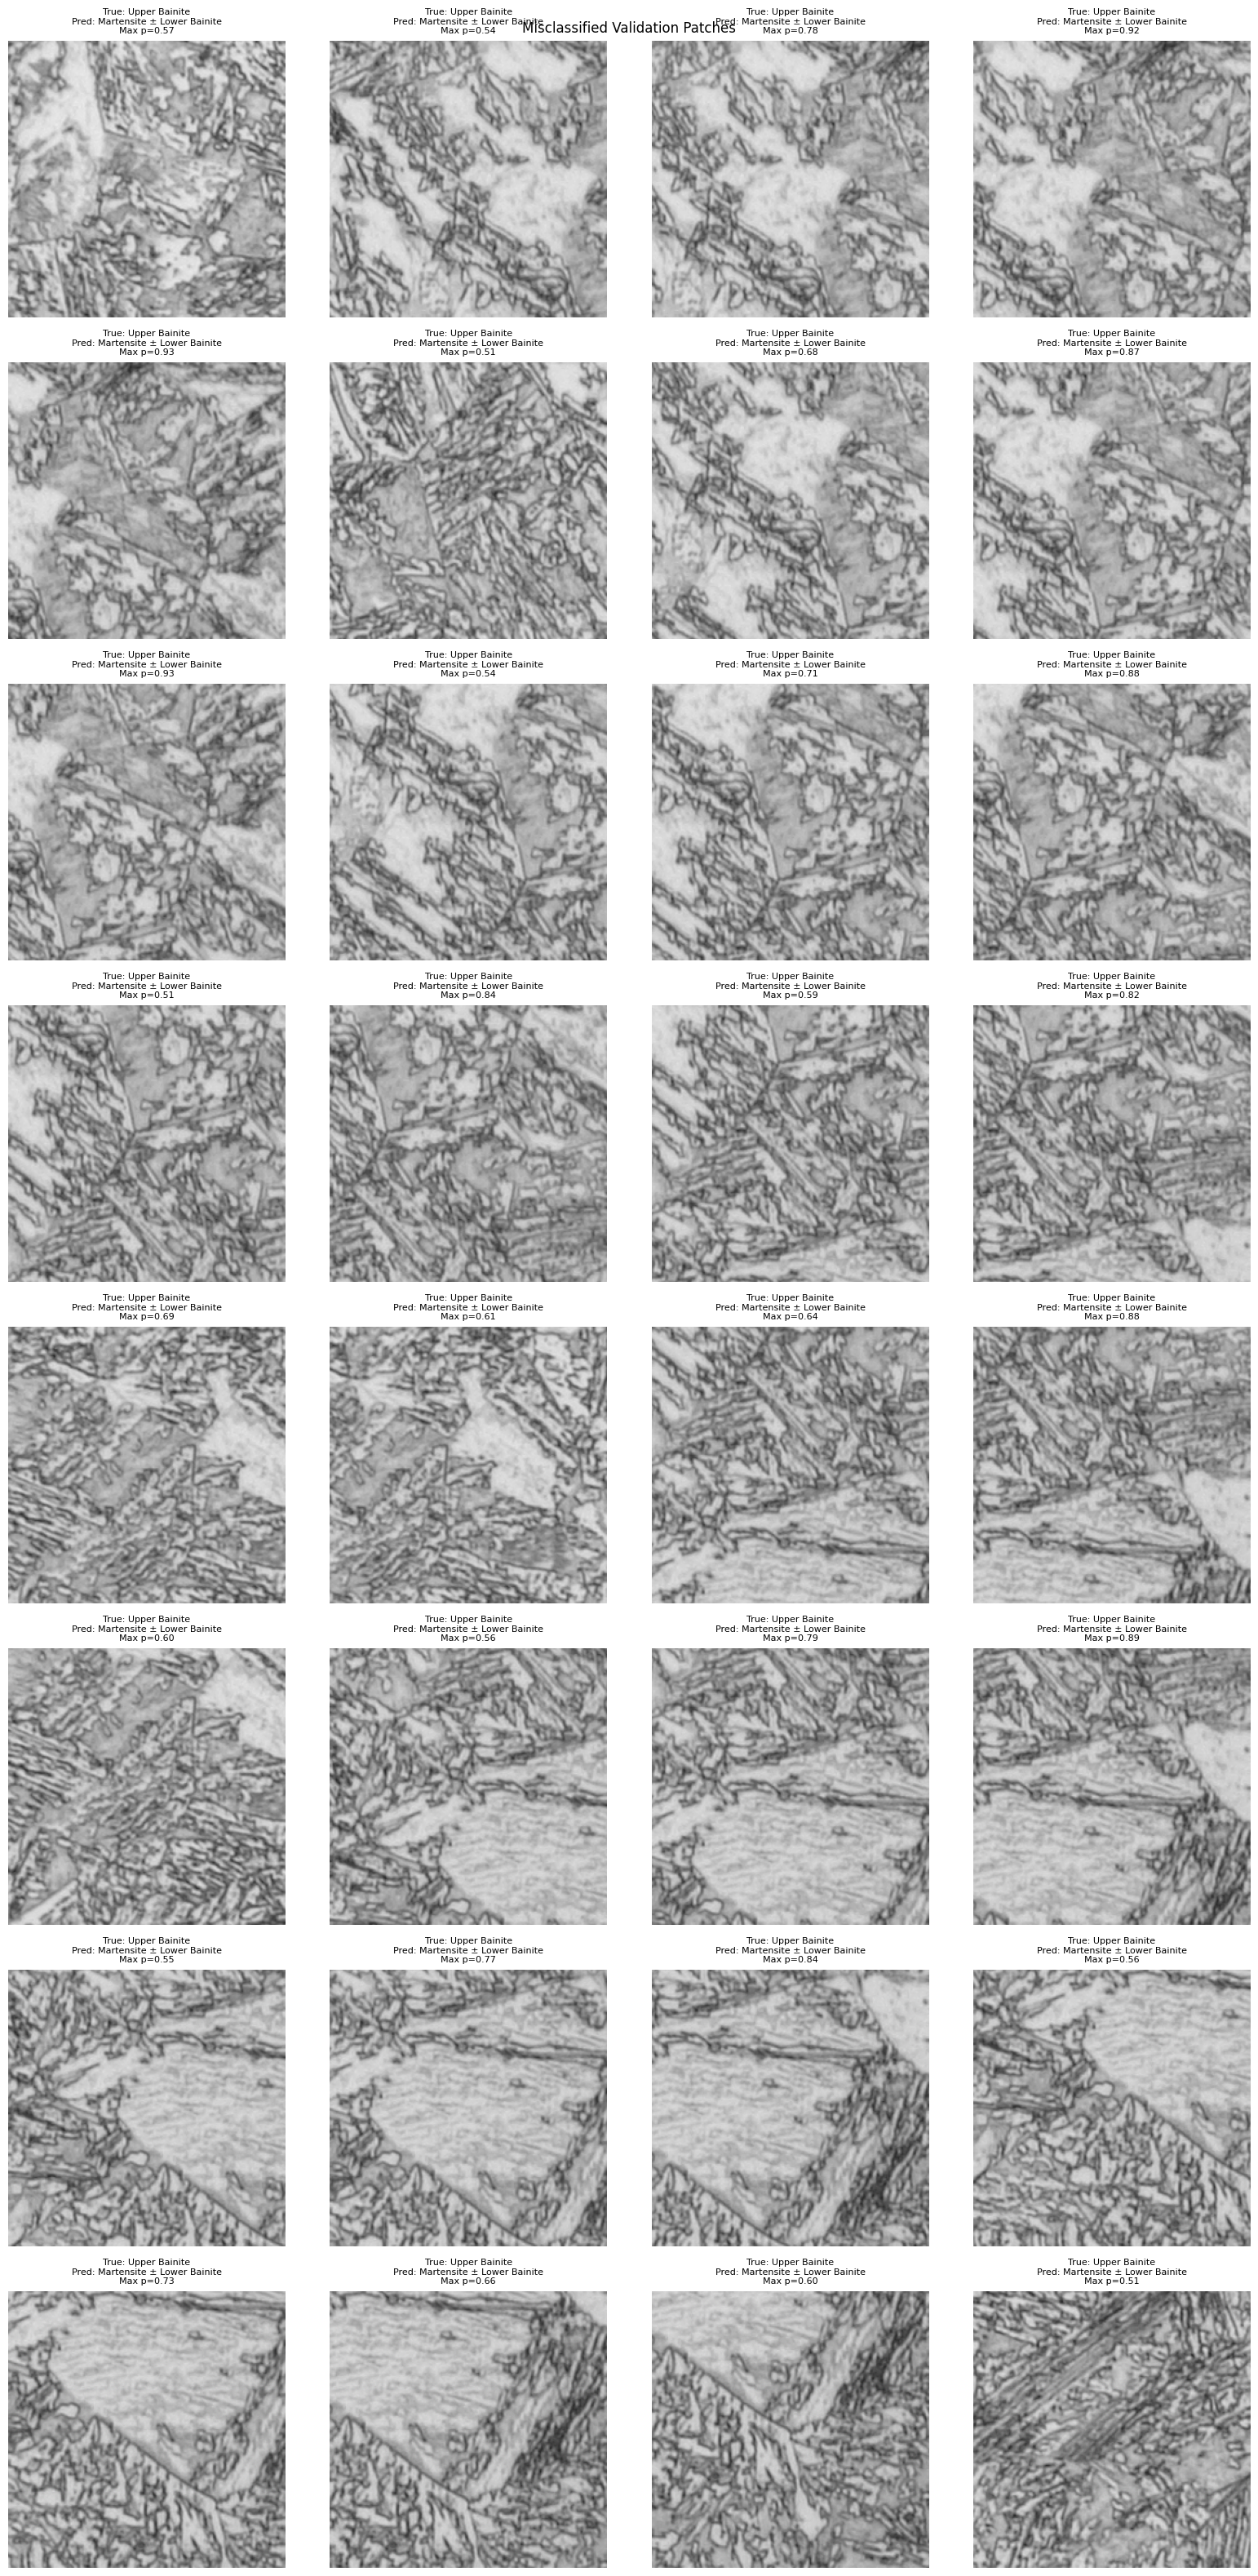

In [88]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

evaluate_and_visualize_single_head(
    model=model,
    loader=val_loader,
    device=device,
    max_show=32
)

